# Start your dataset visualization here  
### modify the analysis_file to the string where the dataframe file (TrajectoryMetrics.csv or other .csv) lives

In [4]:
!pwd

/home/kylemeador/symdesign/jupyter_notebooks


In [5]:
analysis_file = ''  # YOUR ANALYSIS FILE HERE, ex 'path/to/TrajectoryMetrics.csv'

Import the required packages. If you are missing any of these, you should get an environment manager set up (anaconda/miniconda recommended), or try to use pip install numpy (I've never tried this)

In [6]:
import os
import sys
import math
import operator
from itertools import combinations, repeat

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

Magic methods ensure any changes to imported files stay current in the notebook

In [7]:
%load_ext autoreload
%autoreload 2

In [11]:
pd.set_option('display.max_columns', None)  # if you need to view less rows, comment
# pd.set_option('display.max_rows', None)  # if you need to view more rows, uncomment
mean = 'mean'
std = 'std'
idx_slice = pd.IndexSlice

In [8]:
master_metrics = {'average_fragment_z_score':
                      {'description': 'The average fragment z-value used in docking/design',
                       'direction': 'min', 'function': 'normalize', 'filter': True},
                  # 'buns_heavy_total':
                  #     {'description': 'Buried unsaturated H-bonding heavy atoms in the design',
                  #      'direction': 'min', 'function': 'rank', 'filter': True},
                  # 'buns_hpol_total':
                  #     {'description': 'Buried unsaturated H-bonding polarized hydrogen atoms in the design',
                  #      'direction': 'min', 'function': 'rank', 'filter': True},
                  # 'buns_total':
                  #     {'description': 'Total buried unsaturated H-bonds in the design',
                  #      'direction': 'min', 'function': 'rank', 'filter': True},
                  'buried_unsatisfied_hbond_density':
                      {'description': 'Buried Unsaturated Hbonds per Angstrom^2 of interface',
                       'direction': 'min', 'function': 'normalize', 'filter': True},
                  'buried_unsatisfied_hbonds':
                      {'description': 'Total buried unsatisfied H-bonds in the design',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  # 'component_1_symmetry':
                  #     {'description': 'The symmetry group of component 1',
                  #      'direction': 'min', 'function': 'equals', 'filter': True},
                  # 'component_1_name':
                  #     {'description': 'component 1 PDB_ID', 'direction': None, 'function': None, 'filter': False},
                  # 'component_1_number_of_residues':
                  #     {'description': 'The number of residues in the monomer of component 1',
                  #      'direction': 'max', 'function': 'rank', 'filter': True},
                  # 'component_1_max_radius':
                  #     {'description': 'The maximum distance that component 1 reaches away from the center of mass',
                  #      'direction': 'max', 'function': 'normalize', 'filter': True},
                  # 'component_1_n_terminal_helix':
                  #     {'description': 'Whether the n-terminus has an alpha helix',
                  #      'direction': None, 'function': None, 'filter': True},  # Todo binary?
                  # 'component_1_c_terminal_helix':
                  #     {'description': 'Whether the c-terminus has an alpha helix',
                  #      'direction': None, 'function': None, 'filter': True},  # Todo binary?
                  # 'component_1_n_terminal_orientation':
                  #     {'description': 'The direction the n-terminus is oriented from the symmetry group center of mass.'
                  #                     ' 1 is away, -1 is towards', 'direction': None, 'function': None, 'filter': False},
                  # 'component_1_c_terminal_orientation':
                  #     {'description': 'The direction the c-terminus is oriented from the symmetry group center of mass.'
                  #                     ' 1 is away, -1 is towards', 'direction': None, 'function': None, 'filter': False},
                  # 'component_2_symmetry':
                  #     {'description': 'The symmetry group of component 2',
                  #      'direction': 'min', 'function': 'equals', 'filter': True},
                  # 'component_2_name':
                  #     {'description': 'component 2 PDB_ID', 'direction': None, 'function': None, 'filter': False},
                  # 'component_2_number_of_residues':
                  #     {'description': 'The number of residues in the monomer of component 2',
                  #      'direction': 'min', 'function': 'rank', 'filter': True},
                  # 'component_2_max_radius':
                  #     {'description': 'The maximum distance that component 2 reaches away from the center of mass',
                  #      'direction': 'max', 'function': 'normalize', 'filter': True},
                  # 'component_2_n_terminal_helix':
                  #     {'description': 'Whether the n-terminus has an alpha helix',
                  #      'direction': None, 'function': None, 'filter': True},  # Todo binary?
                  # 'component_2_c_terminal_helix':
                  #     {'description': 'Whether the c-terminus has an alpha helix',
                  #      'direction': None, 'function': None, 'filter': True},  # Todo binary?
                  # 'component_2_n_terminal_orientation':
                  #     {'description': 'The direction the n-terminus is oriented from the symmetry group center of mass.'
                  #                     ' 1 is away, -1 is towards', 'direction': None, 'function': None, 'filter': False},
                  # 'component_2_c_terminal_orientation':
                  #     {'description': 'The direction the c-terminus is oriented from the symmetry group center of mass.'
                  #                     ' 1 is away, -1 is towards', 'direction': None, 'function': None, 'filter': False},
                  'contact_count':
                      {'description': 'Number of carbon-carbon contacts across interface',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'core':
                      {'description': 'The number of \'core\' residues as classified by E. Levy 2010',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'coordinate_constraint':
                      {'description': 'Total weight of coordinate constraints to keep design from moving in cartesian '
                                      'space', 'direction': 'min', 'function': 'normalize', 'filter': True},
                  'design_dimension':
                      {'description': 'The underlying dimension of the design. 0 - point, 2 - layer, 3 - space group',
                                      'direction': 'min', 'function': 'normalize', 'filter': True},
                  'divergence_design_per_residue':
                      {'description': 'The Jensen-Shannon divergence of interface residues from the position specific '
                                      'design profile values. Includes fragment & evolution if both are True, otherwise'
                                      ' only includes those specified for use in design.',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'divergence_fragment_per_residue':
                      {'description': 'The Jensen-Shannon divergence of interface residues from the position specific '
                                      'fragment profile', 'direction': 'min', 'function': 'rank', 'filter': True},
                  'divergence_evolution_per_residue':
                      {'description': 'The Jensen-Shannon divergence of interface residues from the position specific '
                                      'evolutionary profile', 'direction': 'min', 'function': 'rank', 'filter': True},
                  'divergence_interface_per_residue':
                      {'description': 'The Jensen-Shannon divergence of interface residues from the typical interface '
                                      'background', 'direction': 'min', 'function': 'rank', 'filter': True},
                  'energy_distance_from_no_constraint_mean':
                      {'description': 'The distance of the design\'s per residue energy from a design with no '
                                      'constraint on amino acid selection', 'direction': 'min', 'function': 'rank',
                       'filter': True},
                  'entity_1_c_terminal_helix':  # TODO make a single metric
                      {'description': 'Whether the entity has a c-terminal helix',
                       'direction': 'max', 'function': 'boolean', 'filter': True},
                  'entity_1_c_terminal_orientation':  # TODO make a single metric
                      {'description': 'Whether the entity c-termini is closer to the assembly core or surface (1 is '
                                      'away, -1 is towards',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'entity_1_max_radius':  # TODO make a single metric
                      {'description': 'The furthest point the entity reaches from the assembly core',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'entity_1_min_radius':  # TODO make a single metric
                      {'description': 'The closest point the entity approaches the assembly core',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'entity_1_n_terminal_helix':  # TODO make a single metric
                      {'description': 'Whether the entity has a n-terminal helix',
                       'direction': 'max', 'function': 'boolean', 'filter': True},
                  'entity_1_n_terminal_orientation':  # TODO make a single metric
                      {'description': 'Whether the entity n-termini is closer to the assembly core or surface (1 is '
                                      'away, -1 is towards)',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'entity_1_name':  # TODO make a single metric
                      {'description': 'The name of the entity', 'direction': None, 'function': None, 'filter': None},
                  'entity_1_number_of_residues':  # TODO make a single metric
                      {'description': 'The number of residues', 'direction': 'min', 'function': 'rank', 'filter': True},
                  'entity_1_radius':  # TODO make a single metric
                      {'description': 'The center of mass of the entity from the assembly core',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'entity_1_symmetry':  # TODO make a single metric
                      {'description': 'The symmetry notation of the entity',
                       'direction': None, 'function': None, 'filter': None},
                  'entity_max_radius_average_deviation':
                      {'description': 'In a multi entity assembly, the total deviation of the max radii of each entity '
                                      'from one another', 'direction': 'min', 'function': 'rank', 'filter': True},
                  'entity_max_radius_ratio_1v2':  # TODO make a single metric
                      {'description': '', 'direction': None, 'function': None, 'filter': None},
                  'entity_maximum_radius':
                      {'description': 'The maximum radius any entity extends from the assembly core',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'entity_min_radius_average_deviation':
                      {'description': 'In a multi entity assembly, the total deviation of the min radii of each entity '
                                      'from one another', 'direction': 'min', 'function': 'rank', 'filter': True},
                  'entity_min_radius_ratio_1v2':  # TODO make a single metric
                      {'description': '', 'direction': None, 'function': None, 'filter': None},
                  'entity_minimum_radius':
                      {'description': 'The minimum radius any entity approaches the assembly core',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'entity_number_of_residues_average_deviation':
                      {'description': 'In a multi entity assembly, the total deviation of the number of residues of '
                                      'each entity from one another',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'entity_number_of_residues_ratio_1v2':  # TODO make a single metric
                      {'description': '', 'direction': None, 'function': None, 'filter': None},
                  'entity_radius_average_deviation':
                      {'description': 'In a multi entity assembly, the total deviation of the center of mass of each '
                                      'entity from one another',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'entity_radius_ratio_1v2':  # TODO make a single metric
                      {'description': '', 'direction': None, 'function': None, 'filter': None},
                  'entity_residue_length_total':
                      {'description': 'The total number of residues in the design',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'errat_accuracy':
                      {'description': 'The overall Errat score of the design',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'errat_deviation':
                      {'description': 'Whether a residue window deviates significantly from typical Errat distribution',
                       'direction': 'min', 'function': 'boolean', 'filter': True},
                  'favor_residue_energy':
                      {'description': 'Total weight of sequence constraints used to favor certain amino acids in design'
                                      '. Only protocols with a favored profile have values',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  # 'fragment_z_score_total':
                  #     {'description': 'The sum of all fragments z-values',
                  #      'direction': None, 'function': None, 'filter': None},
                  'interaction_energy_complex':
                      {'description': 'The two-body (residue-pair) energy of the complexed interface. No solvation '
                                      'energies', 'direction': 'min', 'function': 'rank', 'filter': True},
                  'global_collapse_z_sum':
                      {'description': 'The sum of collapsing sequence regions z-score. Measures the magnitude of '
                                      'additional hydrophobic collapse',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'hydrophobicity_deviation_magnitude':
                      {'description': 'The total deviation in the hydrophobic collapse, either more or less collapse '
                                      'prone', 'direction': 'min', 'function': 'rank', 'filter': True},
                  'interface_area_hydrophobic':
                      {'description': 'Total hydrophobic interface buried surface area',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'interface_area_polar':
                      {'description': 'Total polar interface buried surface area',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'interface_area_to_residue_surface_ratio':
                      {'description': 'The average ratio of interface buried surface area to the surface accessible '
                                      'residue area in the uncomplexed pose',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'interface_area_total':
                      {'description': 'Total interface buried surface area',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'interface_b_factor_per_residue':
                      {'description': 'The average B-factor from each atom, from each interface residue',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'interface_bound_activation_energy':
                      {'description': 'Energy required for the unbound interface to adopt the conformation in the '
                                      'complexed state', 'direction': 'min', 'function': 'rank', 'filter': True},
                  'interface_composition_similarity':
                      {'description': 'The similarity to the expected interface composition given interface buried '
                                      'surface area. 1 is similar to natural interfaces, 0 is dissimilar',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'interface_connectivity_1':  # TODO make a single metric
                      {'description': 'How embedded is interface1 in the rest of the protein?',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'interface_connectivity_2':  # TODO make a single metric
                      {'description': 'How embedded is interface2 in the rest of the protein?',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'interface_connectivity':
                      {'description': 'How embedded is the total interface in the rest of the protein?',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'int_energy_density':
                      {'description': 'Energy in the bound complex per Angstrom^2 of interface area',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'interface_energy':
                      {'description': 'DeltaG of the complexed and unbound (repacked) interfaces',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'interface_energy_complex':
                      {'description': 'Total interface residue energy summed in the complexed state',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'interface_energy_density':
                      {'description': 'Interface energy per interface area^2. How much energy is achieved within the '
                                      'given space?', 'direction': 'min', 'function': 'rank', 'filter': True},
                  'interface_energy_unbound':
                      {'description': 'Total interface residue energy summed in the unbound state',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'interface_energy_1_unbound':  # TODO make a single metric or remove
                      {'description': 'Sum of interface1 residue energy in the unbound state',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'interface_energy_2_unbound':  # TODO make a single metric or remove
                      {'description': 'Sum of interface2 residue energy in the unbound state',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'interface_separation':
                      {'description': 'Median distance between all atom points on each side of the interface',
                       'direction': 'min', 'function': 'normalize', 'filter': True},
                  'interface_separation_core':
                      {'description': 'Median distance between all atom points on each side of the interface core '
                                      'fragment positions',
                       'direction': 'min', 'function': 'normalize', 'filter': True},
                  'interface_secondary_structure_count':
                      {'description': 'The number of unique secondary structures in the interface',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'interface_secondary_structure_fragment_count':
                      {'description': 'The number of unique fragment containing secondary structures in the interface',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  # DSSP G:310 helix, H:α helix and I:π helix, B:beta bridge, E:strand/beta bulge, T:turns,
                  #      S:high curvature (where the angle between i-2, i, and i+2 is at least 70°), and " "(space):loop
                  'interface_secondary_structure_fragment_topology':
                      {'description': 'The Stride based secondary structure names of each unique element where possible'
                                      ' values are - H:Alpha helix, G:3-10 helix, I:PI-helix, E:Extended conformation, '
                                      'B/b:Isolated bridge, T:Turn, C:Coil (none of the above)',
                       'direction': None, 'function': None, 'filter': None},
                  'interface_secondary_structure_fragment_topology_1':  # TODO make a single metric or remove
                      {'description': 'The Stride based secondary structure names of each unique element where possible'
                                      ' values are - H:Alpha helix, G:3-10 helix, I:PI-helix, E:Extended conformation, '
                                      'B/b:Isolated bridge, T:Turn, C:Coil (none of the above)',
                       'direction': None, 'function': None, 'filter': None},
                  'interface_secondary_structure_topology':
                      {'description': 'The Stride based secondary structure names of each unique element where possible'
                                      ' values are - H:Alpha helix, G:3-10 helix, I:PI-helix, E:Extended conformation, '
                                      'B/b:Isolated bridge, T:Turn, C:Coil (none of the above)',
                       'direction': None, 'function': None, 'filter': None},
                  'interface_secondary_structure_topology_1':  # TODO make a single metric or remove
                      {'description': 'The Stride based secondary structure names of each unique element where possible'
                                      ' values are - H:Alpha helix, G:3-10 helix, I:PI-helix, E:Extended conformation, '
                                      'B/b:Isolated bridge, T:Turn, C:Coil (none of the above)',
                       'direction': None, 'function': None, 'filter': None},
                  'interface_local_density':
                      {'description': 'A measure of the average number of atom neighbors for each atom in the interface'
                       , 'direction': 'max', 'function': 'rank', 'filter': True},
                  'multiple_fragment_ratio':
                      {'description': 'The extent to which fragment observations are connected in the interface. Higher'
                                      ' ratio means multiple fragment observations per residue',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'nanohedra_score':
                      {'description': 'Sum of total fragment containing residue match scores (1 / 1 + Z-score^2) '
                                      'weighted by their ranked match score. Maximum of 2/residue',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'nanohedra_score_center':
                      {'description': 'nanohedra_score for the central fragment residues only',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'nanohedra_score_center_normalized':
                      {'description': 'The central Nanohedra Score normalized by number of central fragment residues',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'nanohedra_score_normalized':
                      {'description': 'The Nanohedra Score normalized by number of fragment residues',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'new_collapse_island_significance':
                      {'description': 'The significance of new locations of collapse ranked by proximity to the '
                                      'sequence start',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'new_collapse_islands':
                      {'description': 'The number of new collapse islands found',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'number_fragment_residues_total':
                      {'description': 'The number of residues in the interface with fragment observationsfound',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'number_fragment_residues_center':
                      {'description': 'The number of interface residues that belong to a central fragment residue',
                       'direction': 'max', 'function': 'rank', 'filter': None},
                  'number_hbonds':
                      {'description': 'The number of residues making H-bonds in the total interface. Residues may make '
                                      'more than one H-bond', 'direction': 'max', 'function': 'rank', 'filter': True},
                  'number_of_fragments':
                      {'description': 'The number of fragments found in the pose interface',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'number_of_mutations':
                      {'description': 'The number of mutations made to the pose (ie. wild-type residue to any other '
                                      'amino acid)', 'direction': 'min', 'function': 'normalize', 'filter': True},
                  'observations':
                      {'description': 'Number of unique design trajectories contributing to statistics',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'observed_design':
                      {'description': 'Percent of observed residues in combined profile. 1 is 100%',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'observed_evolution':
                      {'description': 'Percent of observed residues in evolutionary profile. 1 is 100%',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'observed_fragment':
                      {'description': 'Percent of observed residues in the fragment profile. 1 is 100%',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'observed_interface':
                      {'description': 'Percent of observed residues in fragment profile. 1 is 100%',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'percent_core':
                      {'description': 'The percentage of residues which are \'core\' according to Levy, E. 2010',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'percent_fragment':
                      {'description': 'Percent of residues with fragment data out of total residues',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'percent_fragment_coil':
                      {'description': 'The percentage of fragments represented from coiled SS elements',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'percent_fragment_helix':
                      {'description': 'The percentage of fragments represented from an a-helix SS elements',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'percent_fragment_strand':
                      {'description': 'The percentage of fragments represented from a b-strand SS elements',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'percent_interface_area_hydrophobic':
                      {'description': 'The percent of interface area which is occupied by hydrophobic atoms',
                       'direction': 'min', 'function': 'normalize', 'filter': True},
                  'percent_interface_area_polar':
                      {'description': 'The percent of interface area which is occupied by polar atoms',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'percent_residues_fragment_center':
                      {'description': 'The percentage of residues which are central fragment observations',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'percent_residues_fragment_total':
                      {'description': 'The percentage of residues which are represented by fragment observations',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'percent_rim':
                      {'description': 'The percentage of residues which are \'rim\' according to Levy, E. 2010',
                       'direction': 'min', 'function': 'normalize', 'filter': True},
                  'percent_support':
                      {'description': 'The percentage of residues which are \'support\' according to Levy, E. 2010',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  groups:
                      {'description': 'Protocols utilized to search sequence space given fragment and/or evolutionary '
                                      'constraint information', 'direction': None, 'function': None, 'filter': False},
                  'protocol_energy_distance_sum':
                      {'description': 'The distance between the average linearly embedded per residue energy '
                                      'co-variation between specified protocols. Larger = greater distance. A small '
                                      'distance indicates that different protocols arrived at the same per residue '
                                      'energy conclusions despite different pools of amino acids specified for sampling'
                          , 'direction': 'min', 'function': 'rank', 'filter': True},
                  'protocol_similarity_sum':
                      {'description': 'The statistical similarity between all sampled protocols. Larger is more similar'
                                      ', indicating that different protocols have interface statistics that are similar'
                                      ' despite different pools of amino acids specified for sampling',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'protocol_sequence_distance_sum':
                      {'description': 'The distance between the average linearly embedded sequence differences between '
                                      'specified protocols. Larger = greater distance. A small distance indicates that '
                                      'different protocols arrived at the same per residue energy conclusions despite '
                                      'different pools of amino acids specified for sampling',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'rim':
                      {'description': 'The number of \'rim\' residues as classified by E. Levy 2010',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  # 'rmsd':
                  #     {'description': 'Root Mean Square Deviation of all CA atoms between the refined (relaxed) and '
                  #                     'designed states', 'direction': 'min', 'function': 'normalize', 'filter': True},
                  'rmsd_complex':
                      {'description': 'Root Mean Square Deviation of all CA atoms between the refined (relaxed) and '
                                      'designed states', 'direction': 'min', 'function': 'normalize', 'filter': True},
                  'rosetta_reference_energy':
                      {'description': 'Rosetta Energy Term - A metric for the unfolded energy of the protein along with'
                                      ' sequence fitting corrections',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'sequential_collapse_peaks_z_sum':
                      {'description': 'The collapse z-score for each residue scaled sequentially by the number of '
                                      'previously observed collapsable locations',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'sequential_collapse_z_sum':
                      {'description': 'The collapse z-score for each residue scaled by the proximity to sequence start',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'shape_complementarity':
                      {'description': 'Measure of fit between two surfaces from Lawrence and Colman 1993',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'shape_complementarity_core':
                      {'description': 'Measure of fit between two surfaces from Lawrence and Colman 1993 at interface '
                                      'core fragment positions',
                       'direction': 'max', 'function': 'normalize', 'filter': True},
                  'solvation_energy':  # free_energy of desolvation is positive for bound interfaces. unbound - bound
                      {'description': 'The free energy resulting from hydration of the separated interface surfaces. '
                                      'Positive values indicate poorly soluble surfaces',
                       'direction': 'min', 'function': 'rank\n', 'filter': True},
                  'solvation_energy_bound':
                      {'description': 'The desolvation free energy of the separated interface surfaces. Positive values'
                                      ' indicate energy is required to desolvate',
                       'direction': 'min', 'function': 'rank\n', 'filter': True},
                  'solvation_energy_complex':
                      {'description': 'The desolvation free energy of the complexed interface. Positive values'
                                      ' indicate energy is required to desolvate',
                       'direction': 'min', 'function': 'rank\n', 'filter': True},
                  'solvation_energy_unbound':
                      {'description': 'The desolvation free energy of the separated, repacked, interface surfaces. '
                                      'Positive values indicate energy is required to desolvate',
                       'direction': 'min', 'function': 'rank\n', 'filter': True},
                  'support':
                      {'description': 'The number of \'support\' residues as classified by E. Levy 2010',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'symmetry':
                      {'description': 'The specific symmetry type used design (point (0), layer (2), lattice(3))',
                       'direction': None, 'function': None, 'filter': False},
                  'total_interface_residues':
                      {'description': 'The total number of interface residues found in the pose (residue CB within 8A)',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'total_non_fragment_interface_residues':
                      {'description': 'The number of interface residues that are missing central fragment observations',
                       'direction': 'max', 'function': 'rank', 'filter': True},
                  'REU':
                      {'description': 'Rosetta Energy Units. Always 0. We can disregard',
                       'direction': 'min', 'function': 'rank', 'filter': True},
                  'time':
                      {'description': 'Time for the protocol to complete',
                       'direction': None, 'function': None, 'filter': None},
                  'hbonds_res_selection_unbound':
                      {'description': 'The specific h-bonds present in the bound pose',
                       'direction': None, 'function': None, 'filter': None},
                  'hbonds_res_selection_1_unbound':
                      {'description': 'The specific h-bonds present in the unbound interface1',
                       'direction': None, 'function': None, 'filter': None},
                  'hbonds_res_selection_2_unbound':
                      {'description': 'The specific h-bonds present in the unbound interface2',
                       'direction': None, 'function': None, 'filter': None},
                  'dslf_fa13':
                      {'description': 'Rosetta Energy Term - disulfide bonding',
                       'direction': None, 'function': None, 'filter': None},
                  'fa_atr':
                      {'description': 'Rosetta Energy Term - lennard jones full atom atractive forces',
                       'direction': None, 'function': None, 'filter': None},
                  'fa_dun':
                      {'description': 'Rosetta Energy Term - Dunbrack rotamer library statistical probability',
                       'direction': None, 'function': None, 'filter': None},
                  'fa_elec':
                      {'description': 'Rosetta Energy Term - full atom electrostatic forces',
                       'direction': None, 'function': None, 'filter': None},
                  'fa_intra_rep':
                      {'description': 'Rosetta Energy Term - lennard jones full atom intra-residue repulsive forces',
                       'direction': None, 'function': None, 'filter': None},
                  'fa_intra_sol_xover4':
                      {'description': 'Rosetta Energy Term - full atom intra-residue solvent forces',
                       'direction': None, 'function': None, 'filter': None},
                  'fa_rep':
                      {'description': 'Rosetta Energy Term - lennard jones full atom repulsive forces',
                       'direction': None, 'function': None, 'filter': None},
                  'fa_sol':
                      {'description': 'Rosetta Energy Term - full atom solvent forces',
                       'direction': None, 'function': None, 'filter': None},
                  'hbond_bb_sc':
                      {'description': 'Rosetta Energy Term - backbone/sidechain hydrogen bonding',
                       'direction': None, 'function': None, 'filter': None},
                  'hbond_lr_bb':
                      {'description': 'Rosetta Energy Term - long range backbone hydrogen bonding',
                       'direction': None, 'function': None, 'filter': None},
                  'hbond_sc':
                      {'description': 'Rosetta Energy Term - side-chain hydrogen bonding',
                       'direction': None, 'function': None, 'filter': None},
                  'hbond_sr_bb':
                      {'description': 'Rosetta Energy Term - short range backbone hydrogen bonding',
                       'direction': None, 'function': None, 'filter': None},
                  'lk_ball_wtd':
                      {'description': 'Rosetta Energy Term - Lazaris-Karplus weighted anisotropic solvation energy?',
                       'direction': None, 'function': None, 'filter': None},
                  'omega':
                      {'description': 'Rosetta Energy Term - Lazaris-Karplus weighted anisotropic solvation energy?',
                       'direction': None, 'function': None, 'filter': None},
                  'p_aa_pp':
                      {'description': '"Rosetta Energy Term - statistical probability of an amino acid given angles phi'
                          , 'direction': None, 'function': None, 'filter': None},
                  'pro_close':
                      {'description': 'Rosetta Energy Term - to favor closing of proline rings',
                       'direction': None, 'function': None, 'filter': None},
                  'rama_prepro':
                      {'description': 'Rosetta Energy Term - amino acid dependent term to favor certain Ramachandran '
                                      'angles on residue before proline',
                       'direction': None, 'function': None, 'filter': None},
                  'yhh_planarity':
                      {'description': 'Rosetta Energy Term - favor planarity of tyrosine alcohol hydrogen',
                       'direction': None, 'function': None, 'filter': None}}

Importing filter_key

In [10]:
filter_key_df = pd.DataFrame(master_metrics)
display(filter_key_df)

,average_fragment_z_score,buns_heavy_total,buns_hpol_total,buns_total,buns_per_ang,component_1_symmetry,component_1_name,component_1_number_of_residues,component_1_max_radius,component_1_n_terminal_helix,...,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,omega,p_aa_pp,pro_close,rama_prepro,yhh_planarity
description,The average fragment z-value used in docking/d...,Buried unsaturated H-bonding heavy atoms in th...,Buried unsaturated H-bonding polarized hydroge...,Total buried unsaturated H-bonds in the design,Buried Unsaturated Hbonds per Angstrom^2 of in...,The symmetry group of component 1,component 1 PDB_ID,The number of residues in the monomer of compo...,The maximum distance that component 1 reaches ...,Whether the n-terminus has an alpha helix,...,Rosetta Energy Term - backbone/sidechain hydro...,Rosetta Energy Term - long range backbone hydr...,Rosetta Energy Term - side-chain hydrogen bonding,Rosetta Energy Term - short range backbone hyd...,Rosetta Energy Term - Lazaris-Karplus weighted...,Rosetta Energy Term - Lazaris-Karplus weighted...,"""Rosetta Energy Term - statistical probability...",Rosetta Energy Term - to favor closing of prol...,Rosetta Energy Term - amino acid dependent ter...,Rosetta Energy Term - favor planarity of tyros...
direction,min,min,min,min,min,min,None,max,max,None,...,None,None,None,None,None,None,None,None,None,None
function,normalize,rank,rank,rank,normalize,equals,None,rank,normalize,None,...,None,None,None,None,None,None,None,None,None,None
filter,True,True,True,True,True,True,False,True,True,True,...,None,None,None,None,None,None,None,None,None,None


In [5]:
# need {column: {'direction': 'max', 'val': 0.5, 'idx': []}, ...}
def df_filter_index_by_value(df, **kwargs):
    """Take a df and retrieve the indices which have column values greater_equal/less_equal to a value depending
    on whether the column should be sorted max/min
    Args:
        df (pandas.DataFrame): DataFrame to filter indices on
    Keyword Args:
        kwargs (dict): {column: {'direction': 'min', 'value': 0.3, 'idx': ['0001', '0002', ...]}, ...}
    """
    indices_l = []
    for _index in kwargs:
        if kwargs[_index]['direction'] == 'max':
            kwargs[_index]['idx'] = df[df[_index] >= kwargs[_index]['value']].index.to_list()
        if kwargs[_index]['direction'] == 'min':
            kwargs[_index]['idx'] = df[df[_index] <= kwargs[_index]['value']].index.to_list()
    
    return kwargs

In [6]:
def index_intersection(filtered_indices):
    """Take the intersection of provided indices in key, value pairs
    
    Args:
        filtered_indices (dict): {metric: indices, ...}
    Returns:
        (list): All indices in each provided metric
    """
    final_indices = set()
    # find all set union
    for metric in filtered_indices:
        final_indices = set(final_indices) | set(filtered_indices[metric])
        
    # find all set intersection
    for metric in filtered_indices:
        final_indices = set(final_indices) & set(filtered_indices[metric])
    return list(final_indices)

# Load Data

In [10]:
df = pd.read_csv(analysis_file, index_col=0, header=[0])

## Clean Data

In [12]:
df = df.rename_axis(columns=['metric'])
print('Starting size')
display(df.shape)
print('Removing missing values')
df.dropna(inplace=True)  #, thresh= , subset=[])
# if a certain number of columns should be present add -> thresh=100, 
# if a certain column should be checked add -> subset=['nanohedra_score', 'shape_complementarity']
display(df.shape)

Starting size


(649, 419)

Removing energy outliers


(649, 419)

Removing missing values


(649, 419)

In [15]:
# pose_df = df.loc[:, idx_slice['pose',[mean, 'dock', 'seq_design'], :]]
# pose_df = pose_df.droplevel(1, axis=1).droplevel(0, axis=1)
pose_df = df
display(pose_df)

# Visualize data descriptors (mean, standard deviation, min, max, range) for the dataframe

In [50]:
df.describe()

## Filter on metrics in the dataframe 
These crystal means were pulled from Janin et al. 2008 as the set of crystal interface identifiers.  
You can define other identifiers in a similar way (using a dict {key: value} pairs)  
Note, all filtering is done using the >= operator...

In [2]:
crystal_means = {'int_area_total': 570, 'shape_complementarity': 0.63, 'number_hbonds': 5}
other_means = {'total_interface_residues': 52, 'nanohedra_score_center': 5, 'multiple_fragment_ratio': 3.52}

Modify 'design_filters' variable to set your filters of choice. Here other means are used to filter.

In [2]:
design_filters = other_means

In [18]:
print('Starting designs = %d' % len(pose_df))
filtered_indices = {}
for metric in design_filters:
    filtered_indices[metric] = set(pose_df[pose_df[metric] >= design_filters[metric]].index.to_list())
    print('Number of designs passing %s = %d' % (metric, len(filtered_indices[metric])))

Starting designs = 649
Number of designs passing int_area_total = 639
Number of designs passing shape_complementarity = 462
Number of designs passing number_hbonds = 280


In [19]:
final_indices = index_intersection(filtered_indices)
print('Final number of designs passing all metrics is %d' % len(final_indices))

Final number of designs passing all metrics is 198


In [21]:
filtered_df = df.loc[final_indices, :]
display(filtered_df)

### Looking into the contributions of different metrics to the filtered poses
This could easily be done with DataFrame.describe() method, but illustrating other uses of pandas.DataFrame objects here.

In [20]:
numerical_filtered_df = filtered_df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(axis=1)
pose_range_s = numerical_filtered_df.max() - numerical_filtered_df.min()
pose_mean_s = numerical_filtered_df.mean()
pose_std_s = numerical_filtered_df.std()
pose_sum_stats_df = pd.DataFrame()
measures = {'range': pose_range_s, 'mean': pose_mean_s, 'std': pose_std_s}
for n in measures:
    pose_sum_stats_df[n] = measures[n]
pose_sum_stats_df = pd.concat([pose_sum_stats_df], keys=['filtered'], axis=1)

In [27]:
display(pose_sum_stats_df)

## Querying the T33 dataset for terminal helices

In [30]:
# sim_df = df.droplevel(0, axis=1).droplevel(0, axis=1)
sim_df = df
c_1 = set(sim_df[sim_df['entity_1_c_terminal_helix'].astype(bool)].index).intersection(sim_df[sim_df['entity_1_c_terminal_orientation'] > 0].astype(bool).index)
n_1 = set(sim_df[sim_df['entity_1_n_terminal_helix'].astype(bool)].index).intersection(sim_df[sim_df['entity_1_n_terminal_orientation'] > 0].astype(bool).index)
c_2 = set(sim_df[sim_df['entity_2_c_terminal_helix'].astype(bool)].index).intersection(sim_df[sim_df['entity_2_c_terminal_orientation'] > 0].astype(bool).index)
n_2 = set(sim_df[sim_df['entity_2_n_terminal_helix'].astype(bool)].index).intersection(sim_df[sim_df['entity_2_n_terminal_orientation'] > 0].astype(bool).index)
# all_indices = index_intersection(dict(c_1=c_1, n_1=n_1, c_2=c_2, n_2=n_2))
all_indices = sim_df.index

In [31]:
print(len(sim_df))
print(len(c_1))
print(len(n_1))
print(len(c_2))
print(len(n_2))
print(len(all_indices))

179
30
16
56
35
179


In [32]:
df_with_helices = index_intersection(dict(frags_3=all_indices, helical=all_indices))
df_c_1 = index_intersection(dict(frags_3=all_indices, helical=c_1))
df_n_1 = index_intersection(dict(frags_3=all_indices, helical=n_1))
df_c_2 = index_intersection(dict(frags_3=all_indices, helical=c_2))
df_n_2 = index_intersection(dict(frags_3=all_indices, helical=n_2))

print(len(df_with_helices))
print(len(df_c_1))
print(len(df_n_1))
print(len(df_c_2))
print(len(df_n_2))
# all_with_helical = index_intersection(dict(connected_c_1=connected_c_1, connected_n_1=connected_n_1,
#                                            connected_c_2=connected_c_2, connected_n_2=connected_n_2))
# print(len(all_with_helical))
filtered_indices = dict(df_c_1=df_c_1, df_n_1=df_n_1,
                        df_c_2=df_c_2, df_n_2=df_n_2)
final_indices = set()
# find all set union
for metric in filtered_indices:
    final_indices = set(final_indices) | set(filtered_indices[metric])
print('There are %d design with possible terminal helical fusions' % len(final_indices))

179
30
16
56
35
There are 93 design with possible terminal helical fusions


# Protocol Switch point for checking graphs below
The other dataframes described you could make your own by subsetting the data and then run the graphing on whatever subset you choose

In [37]:
# All df have two column levels
protocol_df = pose_df  # all pose metrics, no sd
# protocol_df = design_protocols_df  # all pose, protocol metrics, no sd
# protocol_df = xtal_pose_df  # poses matching crystalline parameters, no sd
# protocol_df = xtal_pose_filtered_df  # same as above, protocol similarity metric appended
# protocol_df = limited_protocol_df  # subset of desired protocols looking at mean and only limit_to_profile

In [38]:
display(protocol_df.corr(method='spearman'))

protocol                                                       pose  \
metric                                     average_fragment_z_score   
protocol metric                                                       
pose     average_fragment_z_score                          1.000000   
         interface_b_factor_per_res                             NaN   
         nanohedra_score                                  -0.491266   
         observations                                      0.011529   
         percent_fragment                                 -0.152573   
         unique_fragments                                 -0.212802   
         buns_heavy_total                                 -0.002064   
         buns_hpol_total                                   0.034060   
         buns_per_ang                                      0.024917   
         buns_total                                        0.008986   
         contact_count                                    -0.063317   
         core                                             -0.056268   
         cst_weight                                        0.035068   
         fsp_energy                                        0.179225   
         int_area_hydrophobic                             -0.089048   
         int_area_polar                                    0.039031   
         int_area_total                                   -0.050864   
         int_composition_diff                             -0.019228   
         int_connectivity_A                                0.059585   
         int_connectivity_B                                0.017138   
         int_energy_context_oligomer_A                    -0.004455   
         int_energy_context_oligomer_B                     0.063021   
         int_energy_res_summary_complex                    0.061745   
         int_energy_res_summary_delta                      0.133014   
         int_energy_res_summary_oligomer                   0.047456   
         int_energy_res_summary_oligomer_A                 0.000845   
         int_energy_res_summary_oligomer_B                 0.083381   
         int_separation                                    0.045679   
         interaction_energy_complex                        0.136464   
         number_hbonds                                     0.033006   
         observed_combined                                -0.029658   
         observed_evolution                                0.024677   
         observed_fragment                                -0.113935   
         percent_core                                     -0.057415   
         percent_int_area_hydrophobic                     -0.176271   
         percent_int_area_polar                            0.176271   
         percent_rim                                       0.019507   
         percent_support                                  -0.019091   
         ref                                              -0.045287   
         rim                                               0.003733   
         rmsd                                              0.002786   
         shape_complementarity                            -0.089521   
         solvation_energy                                  0.050636   
         support                                          -0.010489   
         total_interface_residues                         -0.013532   
         divergence_combined_per_res                      -0.014796   
         divergence_evolution_per_res                     -0.045784   
         divergence_fragment_per_res                       0.041683   
         divergence_interface_per_res                      0.046756   
         protocol_energy_distance_sum                      0.003924   
         protocol_seq_distance_sum                        -0.009299   
         protocol_similarity_sum                           0.069604   

protocol                                                               \
metric               

In [38]:
metrics_of_interest = ['nanohedra_score', 'interface_separation', 'interface_connectivity_1', 'interface_connectivity_2', 'interface_connectivity',
                       'number_hbonds', 'contact_count', 'number_of_mutations',
                       'interface_area_total', 'interface_area_polar', 'interface_area_hydrophobic', 'total_interface_residues', 
                       'core', 'rim', 'support', 'percent_support', 'percent_core', 'percent_rim', 'interface_composition_similarity',
                       'interface_energy', 'solvation_energy', 'interaction_energy_complex', 'percent_fragment', 'observed_design', 'observed_evolution', 
                       'observed_fragment', 'shape_complementarity']

<AxesSubplot:xlabel='metric', ylabel='metric'>

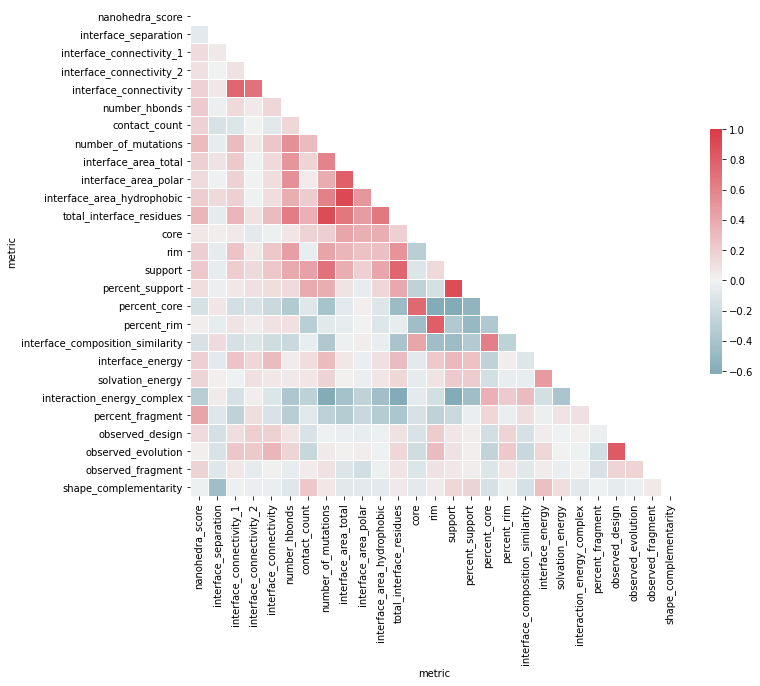

In [40]:
corr_df = protocol_df[metrics_of_interest]
corr = corr_df.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Edit these metrics to look at the correlation between specific metrics you are interested in

### Here you could plot pairs of correlated variables
add the pairs as a tuple in the metric pairs list

-0.029434861957629836

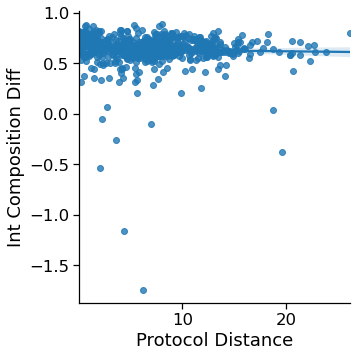

-0.185024865705374

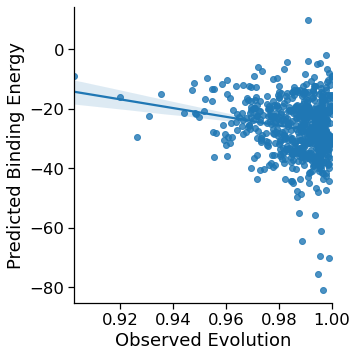

-0.05190526664245933

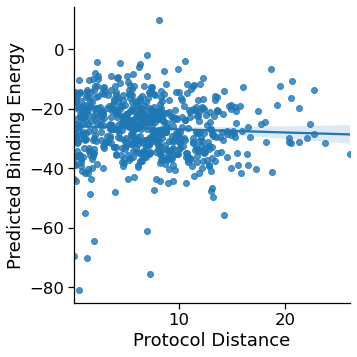

0.21795811793523265

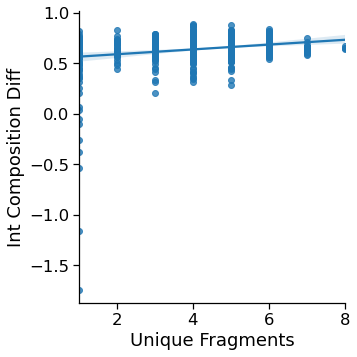

0.2398782586755383

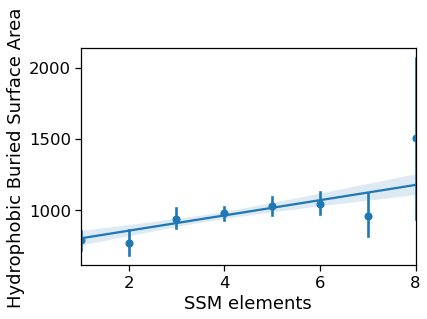

0.251007627103954

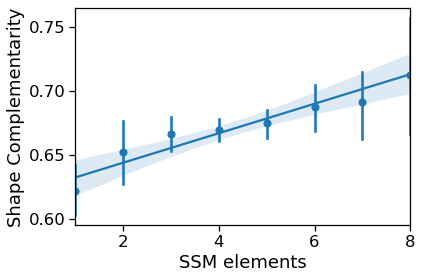

-0.30176420455599384

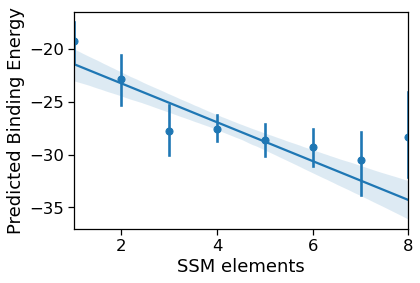

In [42]:
# corr_df = protocol_df.droplevel(0, axis=1)
# display(corr_df)
subset_df = protocol_df
metric_pairs = [
#                 ('divergence_evolution_per_res', 'divergence_interface_per_res'), 
#                 ('divergence_interface_per_res', 'contact_count'), 
#                 ('shape_complementarity', 'int_separation'),
#                 ('percent_support', 'interface_composition_similarity'),
#                 ('percent_rim', 'interface_composition_similarity'),
#                 ('percent_core', 'interface_composition_similarity'),
                ('interface_composition_similarity', 'interface_energy'),
                ('observed_evolution', 'interface_energy'),
                ('number_of_fragments', 'interface_composition_similarity')
#                 ('percent_fragment', 'percent_interface_area_hydrophobic'),
                ]
bar_plot_pairs = [
                  ('number_of_fragments', 'interface_area_hydrophobic'),
                  ('number_of_fragments', 'shape_complementarity'),
                  ('number_of_fragments', 'interface_energy'),
#                   ('unique_fragments', 'int_composition_diff')
                 ]
# for x, y in combinations(metric_pairs):
with sns.plotting_context("notebook", font_scale=1.5):
    for x, y in metric_pairs:
        display(subset_df[x].corr(subset_df[y]))
        ax = sns.lmplot(x=x, y=y, data=subset_df)
        if y == 'interface_energy':
            y = 'predicted_binding_energy'
#         if x == 'protocol_energy_distance_sum':
#             x = 'protocol_distance'
        ax.set(xlabel=' '.join(x.split('_')).title(), ylabel=' '.join(y.split('_')).title())
        plt.show()
with sns.plotting_context("notebook", font_scale=1.5):
    for x, y in bar_plot_pairs:
        display(subset_df[x].corr(subset_df[y]))
    #     ax = sns.catplot(x=x, y=y, kind='violin', data=subset_df)
#         ax = sns.lmplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
        ax = sns.regplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
        if y == 'interface_energy':
            y = 'predicted_binding_energy'
        elif y == 'interface_area_hydrophobic':
            y = 'hydrophobic_buried_surface_area'
        ax.set(xlabel='SSM elements', ylabel=' '.join(y.split('_')).title())  # format into a fancier axis title
        plt.show()
# sns.pairplot(subset_df, x_vars=['shape_complementarity', 'int_energy_res_summary_delta'], y_vars=['unique_fragments'],
#              height=5, aspect=.8, kind="reg")
# sns.pairplot(subset_df, y_vars=['shape_complementarity', 'int_energy_res_summary_delta'], x_vars=['unique_fragments'],
#             aspect=.8, kind="reg") # height=5
# sns.lmplot(x=y, y=x, data=subset_df, x_estimator=np.mean, col='vars', hue='vars')

In [47]:
metrics_of_interest2 = {'observed_evolution': '% Residues Obs. Evol.',
                       'interface_area_total': 'Buried Surface Area (BSA)',
                       'shape_complementarity': 'Shape Complementarity',
                       'interface_energy': 'Predicted Binding Energy', 
#                        'contact_count': 'Carbon-Carbon Contacts', 
                       'percent_interface_area_hydrophobic': 'Hydrophobic BSA',
                       'number_hbonds': 'H-bonds',
                       'interface_buried_hbonds': 'Buried Unsat. H-bonds',
#                        'core', 'rim', 'support']  #'interaction_energy_complex', 'int_area_hydrophobic',
#                              'int_area_polar', 'int_area_total']
                      }

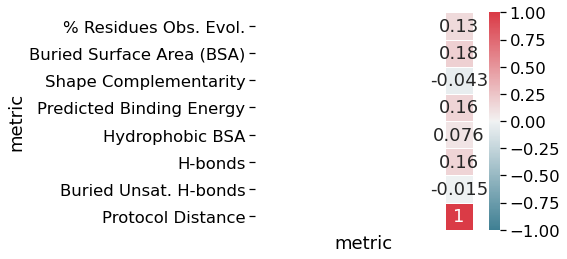

In [33]:
# subset_df = protocol_df.droplevel(0, axis=1)
subset_df = protocol_df
# distance_subset_s = subset_df['energy_distance_from_no_constraint_mean']
protocol_energy = {'energy_distance_from_no_constraint_mean': 'Protocol Distance'}
metrics_of_interest2.update(protocol_energy)
# constraint_corr_df = pd.merge(no_constraint_protocol_df.droplevel(0, axis=1), subset_df, left_index=True, right_index=True)
# constraint_corr_df = subset_df, distance_subset_s
subset_metrics_df = subset_df[list(metrics_of_interest2.keys())]  # + list(protocol_energy.keys())
subset_renamed_metrics_df = subset_metrics_df.rename(columns=metrics_of_interest2)
subset_renamed_metrics_corr_df = subset_renamed_metrics_df.corr(method='spearman')

# Generate a mask to display only correlations of interest
mask = np.ones_like(subset_renamed_metrics_corr_df, dtype=bool)
# display(mask)
for i, row in enumerate(mask):
    mask[i][-1] = False
# display(mask)
# display(mask[: ,-1])
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Plot
with sns.plotting_context("notebook", font_scale=1.5):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 4))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(subset_renamed_metrics_corr_df, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, # cbar_kws={"shrink": .5},
                annot=True, xticklabels=False)

0.08359416233815634

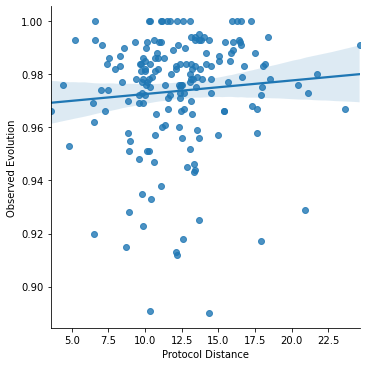

0.14235530302264263

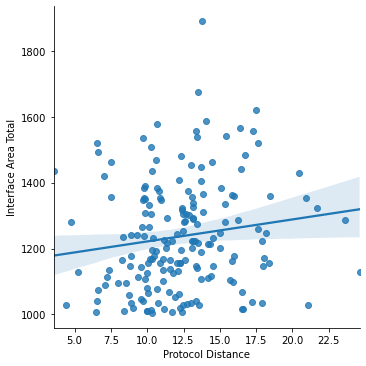

0.0006989059799599137

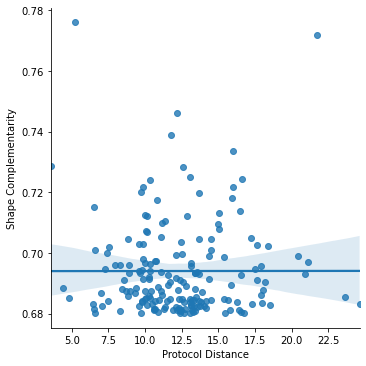

0.15762887381555124

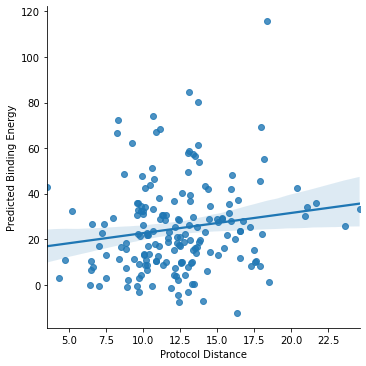

0.10257489806780462

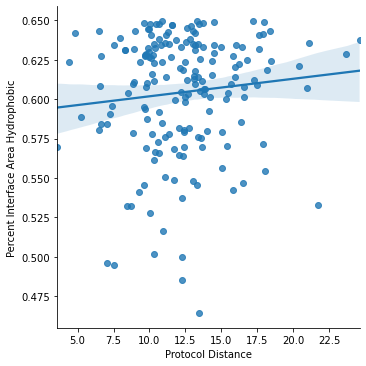

0.10049492225108413

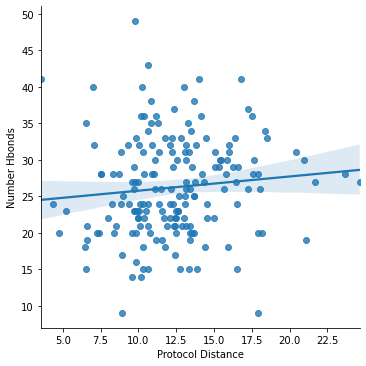

-0.01745079703079328

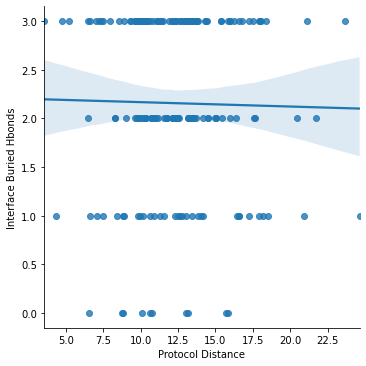

1.0

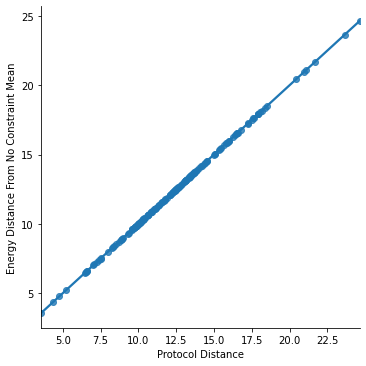

In [58]:
graph_subset_df = subset_metrics_df
metric_pairs = zip(repeat('energy_distance_from_no_constraint_mean'), graph_subset_df.columns.to_list())
# bar_plot_pairs = [
#                   ('unique_fragments', 'int_area_hydrophobic'),
#                   ('unique_fragments', 'shape_complementarity'),
#                   ('unique_fragments', 'int_energy_res_summary_delta'),
#                   ('unique_fragments', 'int_composition_diff')
#                  ]
# for x, y in combinations(metric_pairs):
for x, y in metric_pairs:
    display(graph_subset_df[x].corr(graph_subset_df[y]))
    ax = sns.lmplot(x=x, y=y, data=subset_df)
    if y == 'interface_energy':
        y = 'predicted_binding_energy'
    if x == 'energy_distance_from_no_constraint_mean':
        x = 'protocol_distance'
    ax.set(xlabel=' '.join(x.split('_')).title(), ylabel=' '.join(y.split('_')).title())
    plt.show()
# for x, y in bar_plot_pairs:
#     display(subset_df[x].corr(subset_df[y]))
# #     ax = sns.catplot(x=x, y=y, kind='violin', data=subset_df)
#     ax = sns.lmplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
#     if y == 'int_energy_res_summary_delta':
#         y = 'predicted_binding_energy'
#     elif y == 'int_area_hydrophobic':
#         y = 'hydrophobic_buried_surface_area'
#     ax.set(xlabel='SSC elements', ylabel=' '.join(y.split('_')).title())
#     plt.show()

# BELOW IS NOT WORKING OUT OF THE BOX

In [48]:
protocols_of_interest_freeVnot = {'no_constraint': 'Free', 'combo_profile': 'Constraint'}  # 'limit_to_profile', 'consensus',
protocols_of_interest_all = {'no_constraint': 'Free', 'combo_profile': 'Constraint', 'limit_to_profile': 'Latent Evolution', 'favor_profile': 'Weighted Constraint'}  # 'limit_to_profile', 'consensus',
protocols_of_interest = protocols_of_interest_freeVnot

## Reformat the data to pull specific columns and make a vertically stacked dataframe to produce Bar graphs which have a normalized z-value and are thus comparable across different scalar ranges

In [49]:
# from sklearn.preprocessing import StandardScaler

# normalized_df = design_protocols_df.subtract(design_protocols_df.min())

# .stack() takes a multiindex column header and re-orients (almost transposes) the data onto the index
bar_df = pd.DataFrame(design_protocols_df.stack().stack())
bar_df['Metric'] = bar_df.index.get_level_values(1)
bar_df['Protocol'] = bar_df.index.get_level_values(2)
bar_df = bar_df.rename({0: 'Value'}, axis=1)
# display(bar_df)
# display(bar_df.loc[:, ['Protocol']].isin(protocols_of_interest)['Protocol'])
bar_df = bar_df[bar_df.loc[idx_slice[:, :, :], ['Protocol']].isin(protocols_of_interest.keys())['Protocol']]
bar_df = bar_df[bar_df.loc[idx_slice[:, :, :], ['Metric']].isin(metrics_of_interest.keys())['Metric']]
# bar_df = bar_df[bar_df.loc[:, ['Protocol']] == protocols_of_interest]
display(bar_df)

Value  \
                                    metric                       protocol                     
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile     2.642857   
                                                                 no_constraint     6.400000   
                                    int_area_total               combo_profile  1645.445243   
                                                                 no_constraint  1795.745410   
                                    int_energy_res_summary_delta combo_profile   -36.732404   
...                                                                                     ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint     1.000000   
                                    percent_int_area_hydrophobic combo_profile     0.614864   
                                                                 no_constraint     0.541758   
                                    shape_complementarity        combo_profile     0.639006   
                                                                 no_constraint     0.649500   

                                                                                                      Metric  \
                                    metric                       protocol                                      
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile                    buns_total   
                                                                 no_constraint                    buns_total   
                                    int_area_total               combo_profile                int_area_total   
                                                                 no_constraint                int_area_total   
                                    int_energy_res_summary_delta combo_profile  int_energy_res_summary_delta   
...                                                                                                      ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint            observed_evolution   
                                    percent_int_area_hydrophobic combo_profile  percent_int_area_hydrophobic   
                                                                 no_constraint  percent_int_area_hydrophobic   
                                    shape_complementarity        combo_profile         shape_complementarity   
                                                                 no_constraint         shape_complementarity   

                                                                                     Protocol  
                                    metric                       protocol                      
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    int_area_total               combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    int_energy_res_summary_delta combo_profile  combo_profile  
...                                                                                       ...  
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint  no_constraint  
                                    percent_int_area_hydrophobic combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    shape_complementarity        combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  

[9086 rows x 3 columns]

In [50]:
# First, normalize the data according to protocol groups
# display(bar_df.groupby('Metric').mean())
display(bar_df.groupby('Metric').transform(lambda x: (x - x.mean()) / x.std()))
normalize_df = bar_df.groupby('Metric').transform(lambda x: (x - x.mean()) / x.std())

# display(bar_df.groupby('Metric').min())
bar_s = bar_df.groupby('Metric').mean().squeeze()
# bar_s['int_energy_res_summary_delta'] = bar_s['int_energy_res_summary_delta'] * -1
# inverted_energy_df = bar_df
# inverted_energy_df['Value'] = bar_df.loc[idx_slice[:, bar_df.index.get_level_values(1) == 'int_energy_res_summary_delta', :], 'Value'] * -1
# display(inverted_energy_df)
mean_bar_s = bar_s
final_bar_df = bar_df
# display(mean_bar_s)
# bar_df[bar_df.loc[:, ['Metric']].isin(mean_bar_df)['Protocol']]
new_bar_l = []
for metric, metric_mean in zip(mean_bar_s.index, mean_bar_s):
#     print(metric_mean)
#     print(metric)
#     display(bar_df.loc[idx_slice[:, bar_df.index.get_level_values(1) == metric, :], :])
#     print(bar_df[bar_df.loc[:, ['Metric']] == metric])
#     display(pd.DataFrame(bar_df.loc[idx_slice[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean))
    if metric == 'int_energy_res_summary_delta':
        temp_df = pd.DataFrame(bar_df.loc[idx_slice[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean)
        new_bar_l.append(1 - (temp_df - 1))
    else:
        new_bar_l.append(pd.DataFrame(bar_df.loc[idx_slice[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean))
new_bar_df = pd.concat(new_bar_l)
# display(new_bar_df)
#     new_bar_df = bar_df.loc[idx_slice[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean
    
#     bar_df = bar_df[bar_df.loc[:, ['Metric']] == metric] * metric_mean
# display(bar_df.loc[idx_slice[:, :, :], ['Value']])
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# display(scaler.fit_transform(new_bar_df.loc[idx_slice[:, :, :], ['Value']]))
# final_bar_df['Value'] = scaler.fit_transform(new_bar_df.loc[idx_slice[:, :, :], ['Value']])

final_bar_df['Z-score'] = normalize_df.loc[idx_slice[:, :, :], ['Value']]
# final_bar_df['Value'] = new_bar_df.loc[idx_slice[:, :, :], ['Value']]
final_bar_df.rename(index=metrics_of_interest)

Value
                                    metric                       protocol               
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile  0.158410
                                                                 no_constraint  1.804591
                                    int_area_total               combo_profile  0.505287
                                                                 no_constraint  0.789358
                                    int_energy_res_summary_delta combo_profile -0.729248
...                                                                                  ...
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint  0.812255
                                    percent_int_area_hydrophobic combo_profile -1.458889
                                                                 no_constraint -2.536411
                                    shape_complementarity        combo_profile -0.504788
                                                                 no_constraint -0.370576

[9086 rows x 1 columns]

Value  \
                                    metric                    protocol                  
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint     2.642857   
                                                              Free           6.400000   
                                    Buried Surface Area (BSA) Constraint  1645.445243   
                                                              Free        1795.745410   
                                    Predicted Binding Energy  Constraint   -36.732404   
...                                                                               ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free           1.000000   
                                    Hydrophobic BSA           Constraint     0.614864   
                                                              Free           0.541758   
                                    Shape Complementarity     Constraint     0.639006   
                                                              Free           0.649500   

                                                                                             Metric  \
                                    metric                    protocol                                
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint      Buried Unsat. H-bonds   
                                                              Free            Buried Unsat. H-bonds   
                                    Buried Surface Area (BSA) Constraint  Buried Surface Area (BSA)   
                                                              Free        Buried Surface Area (BSA)   
                                    Predicted Binding Energy  Constraint   Predicted Binding Energy   
...                                                                                             ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free            % Residues Obs. Evol.   
                                    Hydrophobic BSA           Constraint            Hydrophobic BSA   
                                                              Free                  Hydrophobic BSA   
                                    Shape Complementarity     Constraint      Shape Complementarity   
                                                              Free            Shape Complementarity   

                                                                            Protocol  \
                                    metric                    protocol                 
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  Constraint   
                                                              Free              Free   
                                    Buried Surface Area (BSA) Constraint  Constraint   
                                                              Free              Free   
                                    Predicted Binding Energy  Constraint  Constraint   
...                                                                              ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free              Free   
                                    Hydrophobic BSA           Constraint  Constraint   
                                                              Free              Free   
                                    Shape Complementarity     Constraint  Constraint   
                                                              Free              Free   

                                                                           Z-score  
                                    metric                    protocol              
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  0.158410  
                                                              Free        1.804591  
                                    Buried Surface Area (BSA) Constraint  0.505287  
            

In [93]:
def map_level(df, dct, level=0):
    index = df.index
    index.set_levels([[dct.get(item, item) for item in names] if i==level else names
                      for i, names in enumerate(index.levels)], inplace=True)

In [94]:
map_level(final_bar_df, metrics_of_interest, level=1)
map_level(final_bar_df, protocols_of_interest, level=2)

final_bar_df['Metric'] = final_bar_df.index.get_level_values(1)
final_bar_df['Protocol'] = final_bar_df.index.get_level_values(2)
                 
display(final_bar_df)

Value  \
                                    metric                    protocol                  
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint     2.642857   
                                                              Free           6.400000   
                                    Buried Surface Area (BSA) Constraint  1645.445243   
                                                              Free        1795.745410   
                                    Predicted Binding Energy  Constraint   -36.732404   
...                                                                               ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free           1.000000   
                                    Hydrophobic BSA           Constraint     0.614864   
                                                              Free           0.541758   
                                    Shape Complementarity     Constraint     0.639006   
                                                              Free           0.649500   

                                                                                             Metric  \
                                    metric                    protocol                                
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint      Buried Unsat. H-bonds   
                                                              Free            Buried Unsat. H-bonds   
                                    Buried Surface Area (BSA) Constraint  Buried Surface Area (BSA)   
                                                              Free        Buried Surface Area (BSA)   
                                    Predicted Binding Energy  Constraint   Predicted Binding Energy   
...                                                                                             ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free            % Residues Obs. Evol.   
                                    Hydrophobic BSA           Constraint            Hydrophobic BSA   
                                                              Free                  Hydrophobic BSA   
                                    Shape Complementarity     Constraint      Shape Complementarity   
                                                              Free            Shape Complementarity   

                                                                            Protocol  \
                                    metric                    protocol                 
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  Constraint   
                                                              Free              Free   
                                    Buried Surface Area (BSA) Constraint  Constraint   
                                                              Free              Free   
                                    Predicted Binding Energy  Constraint  Constraint   
...                                                                              ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free              Free   
                                    Hydrophobic BSA           Constraint  Constraint   
                                                              Free              Free   
                                    Shape Complementarity     Constraint  Constraint   
                                                              Free              Free   

                                                                           Z-score  
                                    metric                    protocol              
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  0.158410  
                                                              Free        1.804591  
                                    Buried Surface Area (BSA) Constraint  0.505287  
            

## Original view of all protocols
I started with int_energy_context_delta, shape_complementarity, buns_total, contact_count', 'interaction_energy_complex', int_area_hydrophobic, int_area_polar, int_area_total, number_hbonds

After analysis, it seems that some are not useful or the axis need to be moved to visualize. I am also trying different data shapes

I have finally reworked this so that the values are comparable. Scaling by mean and SD of each allows comparisons to be made. I specifically looked at combo_profile (Constrained, Constraint) versus no_constraint (Unconstrained, Free) protocols

/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexi

<AxesSubplot:xlabel='Value', ylabel='Density'>

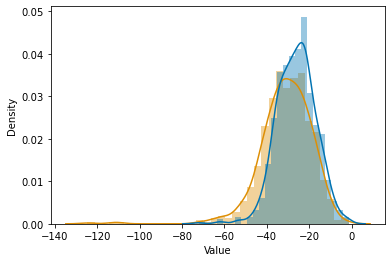

In [52]:
sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Free'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'], color=sns.color_palette('colorblind')[1])
sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Constraint'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'], color=sns.color_palette('colorblind')[0])
# sns.plot.show()

/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


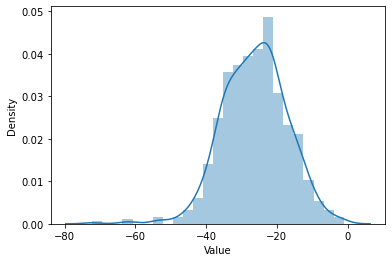

In [53]:
ax = sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Constraint'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


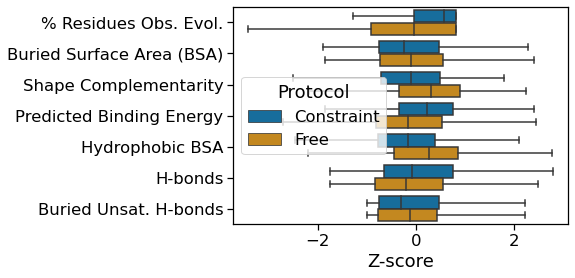

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


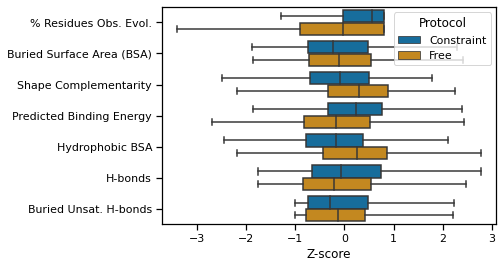

In [54]:
# plt.figure(figsize=(6, 4))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ['Times New Roman']

with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()
with sns.plotting_context("notebook", font_scale=1):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()

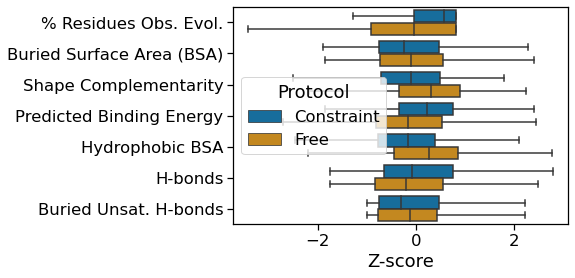

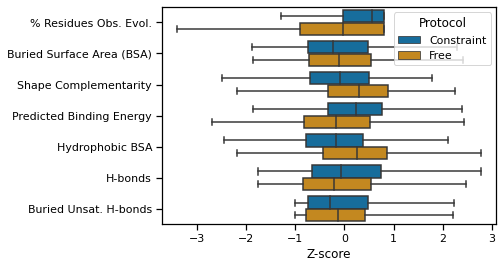

In [55]:
# plt.figure(figsize=(6, 4))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ['Times New Roman']

with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()
with sns.plotting_context("notebook", font_scale=1):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()

In [ ]:
protocol_specific_columns = ['int_energy_res_summary_delta', 'shape_complementarity',
                             'buns_total', 'contact_count', 'number_hbonds']
for metric in protocol_specific_columns:
# for protocol in unique_protocols:
    protocol_bar_df = bar_df[bar_df['Metric'] == metric]
#     plt.figure(figsize=(5, 5))
#     sns.barplot(x="metric", hue="protocol", y='Value', data=protocol_bar_df)
    sns.catplot(x="Protocol", y='Value', kind='box', data=protocol_bar_df)  # hue="protocol", ci='sd'
    print(metric)
    plt.show()

In [ ]:
bsa_bar_df = pd.concat([bar_df[bar_df['Metric'] == 'int_area_hydrophobic'], bar_df[bar_df['Metric'] == 'int_area_polar'], bar_df[bar_df['Metric'] == 'int_area_total']])
# bar_df[bar_df['metric'] == 'int_area_hydrophobic']
# bar_df[bar_df['metric'] == 'int_area_polar']
# bar_df[bar_df['metric'] == 'int_area_total']
# display(bsa_bar_df)

In [ ]:
# with SD
# plt.figure(figsize=(100, 6))
# sns.barplot(x="metric", hue="protocol", y='Value', ci='sd', data=bsa_bar_df)
sns.catplot(x='Metric', y='Value', hue='Protocol', kind='violin', aspect=2, data=bsa_bar_df)  # hue="protocol", ci='sd'
plt.show()

# with 95% confidence interval
plt.figure(figsize=(20, 6))
sns.barplot(x='Metric', hue='Protocol', y='Value', data=bsa_bar_df)
plt.show()

In [ ]:
# .stack() takes a multiindex column header and re-orients (almost transposes) the data onto the index
bar_df = pd.DataFrame(seq_stats_protocol_df.stack().stack())
bar_df['Metric'] = bar_df.index.get_level_values(1)
bar_df['Protocol'] = bar_df.index.get_level_values(2)
bar_df = bar_df.rename({0: 'Value'}, axis=1)
display(bar_df)

In [ ]:
divergence_bar_df = pd.concat([bar_df[bar_df['Metric'] == 'divergence_interface_per_res'], bar_df[bar_df['Metric'] == 'divergence_evolution_per_res']])
box = sns.catplot(x="Metric", y='Value', hue="Protocol", kind='box', aspect=2, data=divergence_bar_df)  #  ci='sd'
# ax = sns.boxplot(x="metric", y='Value', hue="protocol", data=divergence_bar_df)  #, ax=box.ax)  #  ci='sd'
# ax = sns.swarmplot(x="metric", y='Value', hue="protocol", data=divergence_bar_df)  #, ax=box.ax)  #  ci='sd'

In [ ]:
seq_specific_columns = ['divergence_interface_per_res', 'divergence_evolution_per_res']
# display(bar_df)
combo_favor_combined_df = pd.concat([bar_df[bar_df['protocol'] == 'combo_profile'], bar_df[bar_df['protocol'] == 'favor_profile']])
combo_favor_combined_df['protocol'] = 'combination'
bar_df = pd.concat([bar_df, combo_favor_combined_df])
for metric in seq_specific_columns:
# for protocol in unique_protocols:
    protocol_bar_df = bar_df[bar_df['metric'] == metric]
#     plt.figure(figsize=(5, 5))
#     sns.barplot(x="metric", hue="protocol", y='Value', data=protocol_bar_df)
    sns.catplot(x="protocol", y='Value', kind='box', aspect=2, data=protocol_bar_df)  # hue="protocol", ci='sd'
    print(metric)
    plt.show()

## Need to add a couple of metrics to the Dataframe. All subsets are missing these...

In [ ]:
only_metrics_protocol_df = xtal_pose_df.droplevel(0, axis=1)
# only_metrics_protocol_df = columns_to_new_column(only_metrics_protocol_df, division_pairs, mode='truediv')
# display(only_metrics_protocol_df)
# only_metrics_protocol_df['percent_int_area_polar']

## Filtering by additional design filters which lead to good poses

I am going to remove designs not satisfying a couple of criteria that have been useful in past design work. This includes:

buried unsatisfied hydrogen bonds (Stranges and Khulman 2013): 2/1000A

percent polar interface area (): >30%

NOT YET number of h bonds: <10 <8?

In [ ]:
design_requirements = {'percent_int_area_polar': 0.4, 'buns_per_ang': 0.002}  #, 'number_hbonds': 10}
design_requirements.update(crystal_means)

In [ ]:
crystal_filters = {column: {'direction': filter_key_df.loc['direction', column], 'value': design_requirements[column]} 
                   for column in design_requirements}

print('Starting designs = %d' % len(only_metrics_protocol_df))
print('Using filter parameters: %s' % str(crystal_filters))
crystal_filters_with_idx = df_filter_index_by_value(only_metrics_protocol_df, **crystal_filters)
# Take a df and retrieve the indices which have column values greater_equal/less_equal to a value depending
# on whether the column should be sorted max/min
# Args:
#     df (pandas.DataFrame): DataFrame to filter indices on
# Keyword Args:
#     kwargs (dict): {column: {'direction': 'min', 'value': 0.3, 'idx': ['0001', '0002', ...]}, ...}
for _filter in crystal_filters_with_idx:
    print('%s designs = %d' % (_filter, len(crystal_filters_with_idx[_filter]['idx'])))

In [ ]:
# print(crystal_filters_with_idx)
design_indices = {_filter: crystal_filters_with_idx[_filter]['idx'] for _filter in crystal_filters_with_idx}
# display(design_indices[0])
symmetry_and_design_filtered_idx = index_intersection(design_indices)
print('Final number of designs passing all metrics is %d' % len(symmetry_and_design_filtered_idx))
symmetry_and_design_filtered_df = only_metrics_protocol_df.loc[symmetry_and_design_filtered_idx, :]